Import neccessary packages

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16
#from keras.applications import MobileNet,InceptionResNetV2
#from keras.applications.InceptionResNetV2 import preprocess_input
#from keras.applications.xception import Xception, preprocess_input
# load the model
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [2]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '../input/plantvillage/'
width=256
height=256
depth=3
batch_size=64
nb_epochs=50
print(os.listdir("../input"))

['plantdisease']


In [ ]:

file_count = sum(len(files) for _, _, files in os.walk('../input/plantdisease/'))
print(file_count)

total_files = 0
total_dirs = 0
for root, dirs, files in os.walk('../input/plantdisease/'):
    total_files += len(files)
    total_dirs += len(dirs)
print(total_files)
print(total_dirs)

for r, d, f in os.walk('../input/plantdisease/'):
    for file in f:
        if '.txt' in file:
            files.append(os.path.join(r, file))

for f in files:
    print(f)


print([x[0] for x in os.walk('../input/plantdisease/')])

Fetch images from directory

In [ ]:
from PIL import Image

def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width*height

print get_num_pixels("../input/plantdisease/plantvillage/PlantVillage/Pepperbell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot8964.JPG")

In [3]:
#base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(224, 224, 3)) 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [4]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(rate=0.2)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
x=Dropout(rate=0.2)(x)
preds=Dense(15,activation='softmax')(x) #final layer with softmax activation
model=Model(inputs=base_model.input,outputs=preds)

In [5]:
for layer in base_model.layers:
  layer.trainable = False

In [6]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [7]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip = True,
                                                 fill_mode = "nearest",
                                                 zoom_range = 0.3,
                                                 width_shift_range = 0.3,
                                                 height_shift_range=0.3,
                                                 rotation_range=30, validation_split=0.2) #included in our dependencies

train_generator=train_datagen.flow_from_directory('/kaggle/input/plantdisease/plantvillage/PlantVillage',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=batch_size,                
                                                 class_mode='categorical',
                                                 subset='training',shuffle=True,
                                                 seed=42
                                                 )
validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/plantdisease/plantvillage/PlantVillage', # same directory as training data
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42) # set as validation data

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [ ]:
print(len(model.layers))
print(model.layers[174:])
model.summary()

In [8]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

#step_size_train=train_generator.n//train_generator.batch_size
step_size_train=train_generator.n//batch_size
STEP_SIZE_VALID=validation_generator.n//batch_size
print(train_generator.n)
print(train_generator.batch_size)
print(step_size_train)
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=validation_generator,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=20,
                   callbacks=callbacks)

16516
64
258
Epoch 1/20
258/258 [==============================] - 304s 1s/step - loss: 1.5988 - accuracy: 0.5264 - val_loss: 0.7494 - val_accuracy: 0.7812
Epoch 2/20
258/258 [==============================] - 265s 1s/step - loss: 0.8239 - accuracy: 0.7290 - val_loss: 0.6334 - val_accuracy: 0.8287
Epoch 3/20
258/258 [==============================] - 259s 1s/step - loss: 0.6558 - accuracy: 0.7865 - val_loss: 0.4972 - val_accuracy: 0.8497
Epoch 4/20
258/258 [==============================] - 257s 997ms/step - loss: 0.5641 - accuracy: 0.8126 - val_loss: 0.3929 - val_accuracy: 0.8593
Epoch 5/20
258/258 [==============================] - 253s 980ms/step - loss: 0.5018 - accuracy: 0.8328 - val_loss: 0.3601 - val_accuracy: 0.8696
Epoch 6/20
258/258 [==============================] - 249s 964ms/step - loss: 0.4584 - accuracy: 0.8480 - val_loss: 0.2341 - val_accuracy: 0.8797
Epoch 7/20
258/258 [==============================] - 248s 961ms/step - loss: 0.4205 - accuracy: 0.8571 - val_loss: 0.34

Model Summary

In [9]:
model.evaluate_generator(generator=validation_generator,
steps=STEP_SIZE_VALID)

[0.26628577709198, 0.902587890625]

In [10]:
# save model and architecture to single file
os.chdir("/kaggle/working/")
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

Plot the train and val curve

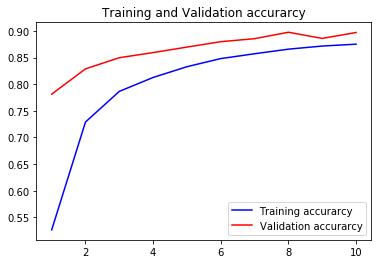

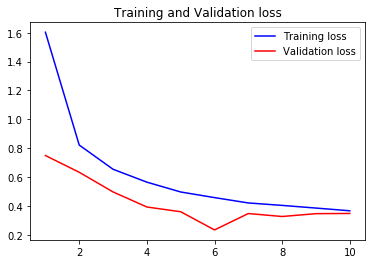

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [ ]:
history_dict = history.history
print(history_dict.keys())

Save model using Pickle

In [ ]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))